In [36]:
from common import Districts
import pandas as pd
from oemof.solph import (EnergySystem, Bus, Sink, Source, Flow,
                         Transformer, GenericStorage)
from oemof.solph import views, processing
import matplotlib.pyplot as plt
import logging
from enum import Enum
import os
from os.path import join
import json
import warnings
from electricity_markets.market_price_generator import create_markets_info
import set_config
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.basicConfig(level=logging.INFO)


INFO:root:DA Price pattern for the year 2019 created
INFO:root:ID Price pattern for the year 2019 created
INFO:root:Electricity market prices (DA,ID,FB,FP) for 2019 created


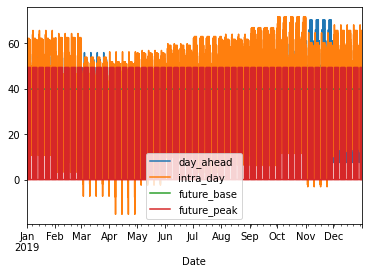

In [37]:
# Get market data as per the price generator
year = 2019
days = 365
RANGE = 24*4*120  # test a week
market_data = create_markets_info(
    year=year, save_csv=True,).head(
    days * 24 * 4)
market_data.plot()

district = Districts.ENAQ
config = set_config.set_configuration(district=district)
district_name = district.value["name"]

GAS_PRICE = 3.66  # EUR per mmBTU
# EUR/mmBTU / (293.07 kWh/mmBTU)
GAS_PRICE = GAS_PRICE / 293.07  # DELETE THE DIVISION TO 100
# a very oversized prize so buying from electricity is extremily discouraged
ELEC_PRICE = 10000
FACTOR_EE = 10


In [38]:
# build the model
# since the models have all the same configuration, the naming of the labels will need to have a naming convention
# b = bus
# s = sink
# g = source/grid
#example
# b_th_enaq
from oemof.solph import Model


label = district_name.lower()
def mlabel(txt):
    return f"{txt}_{label}"

energy_system = EnergySystem(timeindex=config["datetime"][0:RANGE])

# first need a "general electric bus"
b_el_distr = Bus(label=mlabel("b_el_distr"))

# electric supply bus
b_d_el = Bus(label=mlabel("b_d_el"),
                inputs={b_el_distr: Flow()})

# this bus is to exchange energy with other districts:

b_el_exch = Bus(label=mlabel("b_el_exch"),
                inputs={b_el_distr: Flow()})

                 
# add district demands
d_el = Sink(label=mlabel("d_el"),
            inputs={
                b_d_el: Flow(
                    fix=config["el_demand"]["profile"][0:RANGE],
                    nominal_value=1
                )})
energy_system.add(b_el_distr, b_d_el, b_el_exch, d_el)


#model = Model(energy_system)


In [39]:

# add heat bus and district demand
b_d_th = Bus(label=mlabel("b_d_th"))
# add district demands

#b_th_distr = Bus(label=mlabel("b_th_distr"), outputs={b_d_th: Flow()})
s_th = Sink(label=mlabel("s_th"),
            inputs={
                b_d_th: Flow(
                    fix=config["heat_demand"]["profile"][0:RANGE],
                    nominal_value=1
                )})
energy_system.add(b_d_th,s_th) # bus_th_distr




In [40]:

# bus for selling electricity to the markets
# and the 4 markets

# this is the markets bus
b_el_market = Bus(label=mlabel("b_el_market"), 
                   inputs={b_el_distr: Flow()}
                    )

#Prices in EUR/kWh (need to divide by 4 since these are 15 mins intervals)
s_day_ahead = Sink(label=mlabel("s_da"),inputs={
            b_el_market: Flow(
                variable_costs=-
                market_data["day_ahead"][0:RANGE]/1000/4)})

s_intraday = Sink(
    label=mlabel("s_id"),
    inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["intra_day"][0:RANGE]/1000/4)})

s_f_base = Sink(
    label=mlabel("s_fb"),
    inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["future_base"][0:RANGE]/1000/4)})

s_f_peak = Sink(
    label=mlabel("s_fp"),
    inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["future_peak"][0:RANGE]/1000/4)})

energy_system.add(b_el_market, s_day_ahead, s_intraday, s_f_base,s_f_peak)



In [41]:
# Add the external energy sources and related buses

# external gas
b_gas = Bus(label=mlabel("b_gas"))
energy_system.add(b_gas)

if "gas" in config.keys():
    s_gas = Source(label=mlabel('m_gas'), outputs={
                   b_gas: Flow(variable_costs=GAS_PRICE)})  # EUR/kWh
    energy_system.add(s_gas)

b_ext_th = Bus(label=mlabel("b_ext_th"))
energy_system.add(b_ext_th)
if "ext_grid" in config.keys():
    s_ext_th = Source(label=mlabel('s_ext_th'),
                      outputs={b_ext_th: Flow()})  # EUR/kWh
    energy_system.add(s_ext_th)

b_el_grid = Bus(label=mlabel("b_el_grid"), outputs={b_el_distr: Flow()})
s_el_grid = Source(label=mlabel("s_el_grid"),
                   outputs={b_el_grid: Flow(variable_costs=ELEC_PRICE)})  # EUR/kWh

energy_system.add(b_el_grid, s_el_grid)


In [42]:
# add renewable energy buses and technologies

b_el_renew = Bus(label=mlabel("b_el_renew"))
energy_system.add(b_el_renew)
if "PV" in config.keys():
    s_pv = Source(label=mlabel("s_pv"),
                  outputs={b_el_renew: Flow(nominal_value=1, max=config["PV"]["profile"][0:RANGE]*FACTOR_EE)})
    energy_system.add(s_pv)

if "Wind" in config.keys():
    s_wind = Source(label=mlabel("s_wind"),
                    outputs={b_el_renew: Flow(nominal_value=1, max=config["Wind"]["profile"][0:RANGE]*FACTOR_EE)})
    energy_system.add(s_wind)

b_th_renew = Bus(label=mlabel("b_th_renew"))
energy_system.add(b_th_renew)

if "ST" in config.keys():
    s_st = Source(
        label=mlabel("s_st"),
        outputs={
            b_th_renew: Flow(
                nominal_value=1,
                max=config["ST"]["profile"][0:RANGE]*FACTOR_EE)})
    energy_system.add(s_st)


In [43]:
# add combination technologies, like CHP
b_el_prod = Bus(label=mlabel("b_el_prod"), inputs={
                b_el_renew: Flow()}, outputs={b_el_distr: Flow()})
b_th_prod = Bus(label=mlabel("b_th_prod"), inputs={
                b_th_renew: Flow()},) # outputs={b_th_distr: Flow()}
energy_system.add(b_el_prod, b_th_prod)
# add a boiler
if "boiler" in config.keys():
    t_boiler = Transformer(
        label=mlabel('t_boiler'),
        inputs={b_gas: Flow()},
        outputs={b_th_prod: Flow(nominal_value=config["boiler"]["p_kw"])},
        conversion_factors={b_gas: 1, b_th_prod: config["boiler"]["eff"]})
    energy_system.add(t_boiler)

if "chp" in config.keys():
    t_chp = Transformer(
        label=mlabel('t_chp'),
        inputs={b_gas: Flow()},
        outputs={b_el_prod: Flow(nominal_value=config["chp"]["p_kw_el"]),
                 b_th_prod: Flow(nominal_value=config["chp"]["p_kw_th"])},
        conversion_factors={b_el_prod: config["chp"]["eff_el"],
                            b_th_prod: config["chp"]["eff_th"]})
    energy_system.add(t_chp)



In [44]:
if "heat_pump" in config.keys():
    t_hp = Transformer(
        label=mlabel('t_hp'),
        inputs={b_el_prod: Flow()},
        outputs={b_th_prod: Flow(nominal_value=config["heat_pump"]["p_kw_th"])},
        conversion_factors={b_th_prod: config["heat_pump"]["cop"][0:RANGE]})
    energy_system.add(t_hp)



In [45]:
# att electric storage
if "batt_sto" in config.keys():
    batt_sto = GenericStorage(
        label=mlabel('sto_batt'),
        inputs={
            b_el_prod: Flow(nominal_value=config["batt_sto"]["charge_cap"])},
        outputs={
            b_el_prod: Flow(nominal_value=config["batt_sto"]["discharge_cap"])},
        loss_rate=config["batt_sto"]["loss_rate"],
        nominal_storage_capacity=config["batt_sto"]["capacity"],
        inflow_conversion_factor=config["batt_sto"]["charge_eff"],
        outflow_conversion_factor=config["batt_sto"]["disch_eff"],
        initial_storage_level=0,
        balanced=False)
    energy_system.add(batt_sto)





In [46]:
# This needs to be fixed to work with volumes and heat insulation properties
# Will find a better formulation later
bus_th_distr =  Bus(label=mlabel("b_th_distr"), inputs={b_th_prod: Flow(),b_ext_th: Flow() }, outputs={b_d_th: Flow()})
energy_system.add(bus_th_distr)

if "heat_sto" in config.keys():
    heat_sto = GenericStorage(
        label=mlabel('sto_heat'),
        inputs={
            bus_th_distr: Flow(nominal_value=config["heat_sto"]["charge_cap"])},
        outputs={
            bus_th_distr: Flow(nominal_value=config["heat_sto"]["discharge_cap"])},
        loss_rate=config["heat_sto"]["loss_rate"],
        nominal_storage_capacity=config["heat_sto"]["capacity"],
        inflow_conversion_factor=config["heat_sto"]["charge_eff"],
        outflow_conversion_factor=config["heat_sto"]["disch_eff"],
        initial_storage_level=0,
        balanced=False)
    energy_system.add(heat_sto)




In [47]:
'''
Build a pyomo Model and add constraints for the proper sinks
:param energy_system: Energy System with the appropiate markets.
'''
# Build model
from oemof.solph import Model
import pyomo.environ as po

model = Model(energy_system)


In [48]:

bus_el_out = [n for n in energy_system.nodes if n.label == mlabel("b_el_market")][0]
bus_el_out


"<oemof.solph.network.bus.Bus: 'b_el_market_enaq'>"

In [49]:

# Before anything I need the shape of the future_peak in the shape of 1
# and 0
# electric bus
bus_el_out = [n for n in energy_system.nodes if n.label == mlabel("b_el_market")][0]
# check output
key = [k for k in bus_el_out.outputs.keys() if "s_fp" in str(k)][0]
future_base_flow_price = bus_el_out.outputs[key].variable_costs

# Add Market Constraints

# Constraint for the Day Ahead Market
# i = inflow
# o = outflow
flows = {}
for (i, o) in model.flows:
    if str(i) == mlabel("b_el_market") and str(o) == mlabel("s_da"):
        flows[(i, o)] = model.flows[i, o]

for (i, o) in flows:
    for t in model.TIMESTEPS:
        if t % 4 != 0:
            # ToDo: Change name to day_ahead
            limit_name = "day_ahead_{}={}".format(t, t - t % 4)
            setattr(model, limit_name, po.Constraint(
                rule=(model.flow[i, o, t] - model.flow[i, o, t - t % 4] == 0)))

# Constraint for the Future Peak
flows = {}

for (i, o) in model.flows:
    if str(i) == mlabel("b_el_market") and str(o) == mlabel("s_fb"):
        flows[(i, o)] = model.flows[i, o]

for (i, o) in flows:
    for t in model.TIMESTEPS:
        if t != 0:
            limit_name = "future_base_{}={}".format(t, 0)
            setattr(model, limit_name, po.Constraint(
                rule=(model.flow[i, o, t] - model.flow[i, o, 0] == 0)))

# Constraint for the Future Base
# what are the time steps for decision making?
# I rather look at the shape of the cost of the flow to see
# if the price is 0, then constraint is 0
# if price is not 0, then the price is equal

flows = {}
for (i, o) in model.flows:
    if str(i) == mlabel("b_el_market") and str(o) == mlabel("s_fp"):
        flows[(i, o)] = model.flows[i, o]

times_future_base_constraint = [t for t in model.TIMESTEPS if abs(
    future_base_flow_price[t]) > 0.001]  # a small tolerance there

for time_step in times_future_base_constraint[1:]:  # for each day
    # range = 12*4 #time steps for the constraint, 13 hrs after 8 am, until
    # 20:45
    # the last bit of the 13h is not included
    t0 = times_future_base_constraint[0]
    for (i, o) in flows:
        limit_name = "future_peak_{}={}".format(time_step, t0)
        setattr(model, limit_name, po.Constraint(
            rule=(model.flow[i, o, t0] - model.flow[i, o, time_step] == 0)))

times_fb_null = [
    t for t in model.TIMESTEPS if t not in times_future_base_constraint]
for t in times_fb_null:
    limit_name = "future_peak_null_{}".format(t)
    setattr(
        model,
        limit_name,
        po.Constraint(
            rule=(
                model.flow[i, o, t] == 0)))

In [50]:
model.solve(solver="cbc",
                solve_kwargs={'tee': False},
                solver_io='lp',
                cmdline_options={'ratio': 0.1})
energy_system = model.es
if model.solver_results.Solver[0].Status != "ok":
    raise AssertionError("Solver did not converge. Stopping simulation")

energy_system.results['valid'] = True
energy_system.results['solve_and_write_data'] = processing.results(
    model)
energy_system.results['solve_and_write_data'] = views.convert_keys_to_strings(
    energy_system.results['solve_and_write_data'])
energy_system.results['meta'] = processing.meta_results(
    model)


INFO:root:Optimization successful...


In [51]:
results = energy_system.results['solve_and_write_data']
results_list = []
for k in results.keys():
    if "flow" in list(results[k]['sequences'].keys()):
        flow = results[k]['sequences']['flow']
        if True:
            key_name = str(k)
            for s in [
                    "(", "'", ")"]:  # remove ( ' ) characters
                key_name = key_name.replace(s, "")
            flow.rename(key_name, inplace=True)
            flow_df = pd.DataFrame(flow)
            results_list.append(flow_df)

import datetime
now = datetime.datetime.now()

current_time = now.strftime("%y%m%d%H%M%S")

results = pd.concat(results_list, axis=1)
results.to_csv(f"results_{district_name}_{current_time}.csv")
   

<AxesSubplot:>

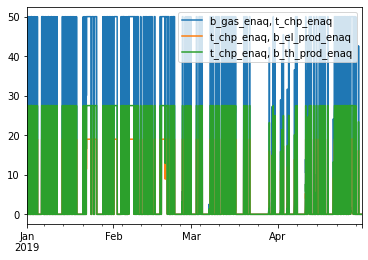

In [52]:
# CHP Results
cols = [c for c in results.columns if "t_chp" in c]
results[cols].plot()

<AxesSubplot:>

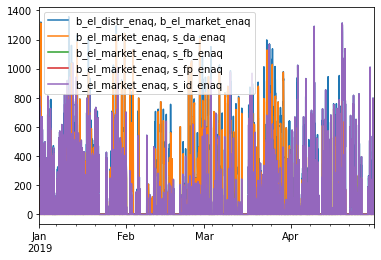

In [53]:
#marktes:
cols = [c for c in results.columns if mlabel("b_el_market") in c]
results[cols].plot()

<AxesSubplot:>

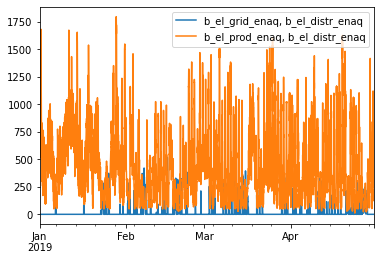

In [54]:
cols = [c for c in results.columns if mlabel("b_el_distr") in c.split(",")[1]]
results[cols].plot()

19.000000000000004

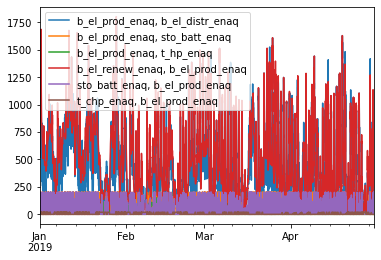

In [55]:
cols = [c for c in results.columns if mlabel("b_el_prod") in c]
results[cols].plot()
config["chp"]["p_kw_el"]

In [56]:
# Sum of the total energy flows from bus to bus
total_energy = results.sum() / 4  # Since it it was in 15min intervals

# lables to fetch values from the dits
da = mlabel("s_da")
id = mlabel("s_id")
fb = mlabel("s_fb")
fp = mlabel("s_fp")
market = mlabel("b_el_market")
distr = mlabel("b_el_distr")

# Income 
income = {
    "income, da": results[f"{market}, {da}"].values * market_data["day_ahead"][0:RANGE].values,
    "income, id": results[f"{market}, {id}"].values * market_data["intra_day"][0:RANGE].values,
    "income, fb": results[f"{market}, {fb}"].values * market_data["future_base"][0:RANGE].values,
    "income, fp": results[f"{market}, {fp}"].values * market_data["future_peak"][0:RANGE].values}

income["income, total"] = income["income, da"] + \
    income["income, id"] + income["income, fb"] + income["income, fp"]

income_total = {k: round(v.sum() / 4, 1) for k, v in income.items()}
income_total["average_price EUR/MWh"] = income_total["income, total"] / \
    total_energy[f"{distr}, {market}"]
income_total = pd.Series(income_total)
kpis = total_energy.append(income_total)

#expenses:
# So far only two expenses are here: Gas (payed by kWh) and electricity (EUR/kWH)

expenses = {
    "expense, gas, EUR": results[f"{market}, {da}"].values * GAS_PRICE,
    "expense, electricity, EUR": results[f"{market}, {id}"].values * ELEC_PRICE,}
expenses_total = {k: round(v.sum() / 4, 1) for k, v in expenses.items()}
expenses_total = pd.Series(expenses_total)
kpis = kpis.append(expenses_total)



In [57]:
# operational hours
pv = mlabel("s_pv")
st = mlabel("s_st")
wt = mlabel("s_wind")
b_el_r = mlabel("b_el_renew")
b_th_r = mlabel("b_th_renew")
b_el_p = mlabel("b_el_prod")
b_th_p = mlabel("b_th_prod")
chp = mlabel("t_chp")
hp = mlabel("t_hp")


op_hours = {}
if "PV" in config.keys():
    op_hours["hours, PV"]= results[f"{pv}, {b_el_r}"].values
if "Wind" in config.keys():
    op_hours["hours, WT"]= results[f"{wt}, {b_el_r}"].values 
if "ST" in config.keys():
    op_hours["hours, ST"]= results[f"{st}, {b_th_r}"].values 
if "chp" in config.keys():    
    op_hours["hours, CHP"]= results[f"{chp}, {b_el_p}"].values
if "heat_pump" in config.keys():    
    op_hours["hours, HP"]= results[f"{hp}, {b_th_p}"].values 

try:
    op_hours = {k: [1 if x >0 else 0 for x in v] for k, v in op_hours.items()}
    op_hours = {k: sum(v)/4 for k, v in op_hours.items()}
    op_hours = pd.Series(op_hours)
    kpis = kpis.append(op_hours)
except:
    pass

kpis.to_csv(f"kpis_{district_name}.csv")


dict_keys(['name', 'datetime', 'gas', 'boiler', 'heat_pump', 'heat_demand', 'PV', 'ST', 'Wind', 'el_demand', 'chp', 'electrolizer', 'heat_sto', 'batt_sto'])